In [253]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import statistics
import math
from shutil import copyfile
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro



In [369]:
position = ["position_x","position_y","position_z"]
target= ["target_position_x","target_position_y","target_position_z"]
total_time = "time"

max_distance_error = 4.0

max_height_error = 3*max_distance_error/4
max_contraction_error = 1.0
feedback_types = ['Visual', 'Glove', 'Bracelets']
task_types = ["time", "1st_waypoint_time", "extension_time", "2nd_waypoint_time", "3rd_waypoint_time", "contraction_time"]
error_types = ["height_error", "x_error", "z_error", "extension_error"]

title_dict = {"position_x" : "position x", "position_y" : "height", "position_z" : "position Y" }
error_dict = {"x_error" : "x error", "z_error": "y error", "height_error": "height error", "extension_error": "extension error"}
label_dict = {"position_x" : "Distance [m]", "position_y" : "Height [m]", "position_z" : "Distance [m]", "extension" : ["Average distance from COM [m]"] }
time_dict = {"time": "Total time", "1st_waypoint_time": "Time to reach 1st waypoint", "extension_time": "Time to reach correct expansion", "2nd_waypoint_time": "Time to reach 2nd waypoint", "3rd_waypoint_time": "Time to reach 3rd waypoint", "contraction_time": "Time to reach contraction state"}

#position_x,position_y,position_z,target_position_x,target_position_y,target_position_z,time,extension,target_extension,height_error,distance_to_waypoint,extension_error,reaching_height_time

# Arrangement of the log files in folder

In [4]:
folders = ['Raw', 'Visual', 'Glove', 'Bracelets']
for folder in folders:
    try:
        os.mkdir(folder + "\\sorted")
        os.mkdir(folder)
    except:
        print("Folder", folder, "already existing")

Folder Raw already existing
Folder Visual already existing
Folder Glove already existing
Folder Bracelets already existing


In [30]:
def move_in_correct_folder(filename):
    if "drone" in filename :
        newfilename = "Raw" +"\\" + filename
        os.replace(filename, newfilename)    
    else:
        types_of_feedback = ["Visual", "Glove", "Bracelets"]
        for fb_type in types_of_feedback:
            if fb_type in filename :
                newfilename = fb_type +"\\" + filename
                os.replace(filename, newfilename)
                

def organise_logs():
    all_files =  glob.glob("*.csv")
    for file in all_files:  
        move_in_correct_folder(file)

        
def correct_file_length():
    for fb_type in feedback_types:
        all_files =  glob.glob(fb_type +"\\*.csv")
        for file in all_files:    
            df = pd.read_csv(file)
            for i in range(1,10):
                if math.isnan(df["target_extension"][df.index[-i]]): 
                    last_element = i
                    df = df.iloc[0:-last_element] 
            df.to_csv(file, index=False)
        
def correct_contraction_time():
    for fb_type in feedback_types:
        all_files =  glob.glob(fb_type +"\\*.csv")
        for file in all_files:
            df = pd.read_csv(file)
            total_time = df["time"].iloc[-1]
            initial_time = df["time"] [next((i for i, x in enumerate(df["3rd_waypoint_time"]) if x), None)]
            df['contraction_time'].iloc[-1] = total_time - initial_time
            df.to_csv(file, index=False)

def sort_files():
    for fb_type in feedback_types:
        all_files =  glob.glob(fb_type +"\\*.csv")
        for file in all_files:
            splitting = file.split('sub')
            print(fb_type+ "\\sorted\\"+ splitting[1])
            copyfile(file, fb_type+ "\\"+splitting[1])

def correct_extension_error():
    for fb_type in feedback_types:
        all_files =  glob.glob(fb_type +"\\sorted\\*.csv")
        for file in all_files:
            zero_value = 0
            df = pd.read_csv(file)
            ext_error = df["extension_error"]
            for i in range(3,len(ext_error)):
                if ext_error[i] == ext_error[i-1] and ext_error[i]== ext_error[i-2]: zero_value = ext_error[i]
                if ext_error[i] == zero_value :  ext_error[i] = 0
            df["extension_error"] = ext_error
#             initial_time = df["time"] [next((i for i, x in enumerate(df["3rd_waypoint_time"]) if x), None)]
#             df['contraction_time'].iloc[-1] = total_time - initial_time
            df.to_csv(file, index=False)
    return df

Put the files in the correct folders

In [ ]:
# correct_file_length()

In [ ]:
# correct_contraction_time()

In [ ]:
# organise_logs()

In [113]:
# correct_extension_error()

# Trajectory plots

In this section, we present the plot of the positions (x, y and z) compared to the target positions.

Further more, a plot of the expansion error is plotted.

Each time, the position (or the expansion) is considered to be valid if it enters the margin around the target position (shown with dashed lines on the plots).

The x axis is always the real time.

# Question to Claudio
Do you know an official name to call this acceptance margin ?

In [114]:
def plot_all_sub_trajectories(information_type):
    
    
    if information_type == "extension":
        max_error = max_contraction_error
    elif information_type == "position_y":
        max_error = max_height_error
    else: max_error = max_distance_error
        
    fig, ax = plt.subplots(nrows=18, ncols=3, figsize=(20,100))
    row = 0
    column = 0
    
    i = 0
    
    for feedback_type in feedback_types:
        files = glob.glob(feedback_types[column]+"\\sorted\\*.csv")
        row = 0
        for file in files:
            i += 1
            
            data = pd.read_csv(file)
            
            ax[row][column].plot(data[information_type], label = "Actual " + title_dict[information_type])
            if information_type == "position_y" : 
                
                ax[row][column].plot(data["target_"+information_type]+1+np.ones(len(data["height_error"]))*0.1*max_error,'--k', linewidth = '0.8', label = 'Acceptance margin')
                ax[row][column].plot(data["target_"+information_type]+1-np.ones(len(data["height_error"]))*0.1*max_error,'--k', linewidth = '0.8')
                ax[row][column].plot(data["target_"+information_type]+1, label = 'Target ' + title_dict[information_type])
            else:
                ax[row][column].plot(data["target_"+information_type]+np.ones(len(data["height_error"]))*0.1*max_error, '--k', linewidth = '0.8', label = 'Acceptance margin')
                ax[row][column].plot(data["target_"+information_type]-np.ones(len(data["height_error"]))*0.1*max_error,'--k', linewidth = '0.8')
                ax[row][column].plot(data["target_"+information_type], label = 'Target ' + title_dict[information_type])

            if row == 0: ax[row][column].set_title(feedback_type + " feedback")
            ax[row][column].set_xlabel('Time [s]')
            ax[row][column].set_ylabel('Height [m]')
            ax[row][column].legend()            
            row += 1
        column+=1
    
def plot_extension_error():
    fig, ax = plt.subplots(nrows=18, ncols=3, figsize=(20,100))
    row = 0
    column = 0
    
    for feedback_type in feedback_types:
        files = glob.glob(feedback_types[column]+"\\sorted\\*.csv")
        row = 0
        for file in files:
            data = pd.read_csv(file)
            ax[row][column].plot(data["extension_error"], label = "Extension error")
            ax[row][column].plot(np.ones(len(data["extension_error"]))*0.1,'--k', linewidth = '0.8', label = "Acceptance margin")
            ax[row][column].plot(-np.ones(len(data["extension_error"]))*0.1,'--k', linewidth = '0.8')
            if row == 0: ax[row][column].set_title(feedback_type + " feedback")
            ax[row][column].set_xlabel('Time [s]')
            ax[row][column].set_ylabel('Extension error [m]')
            ax[row][column].legend()
            row += 1
        column+=1


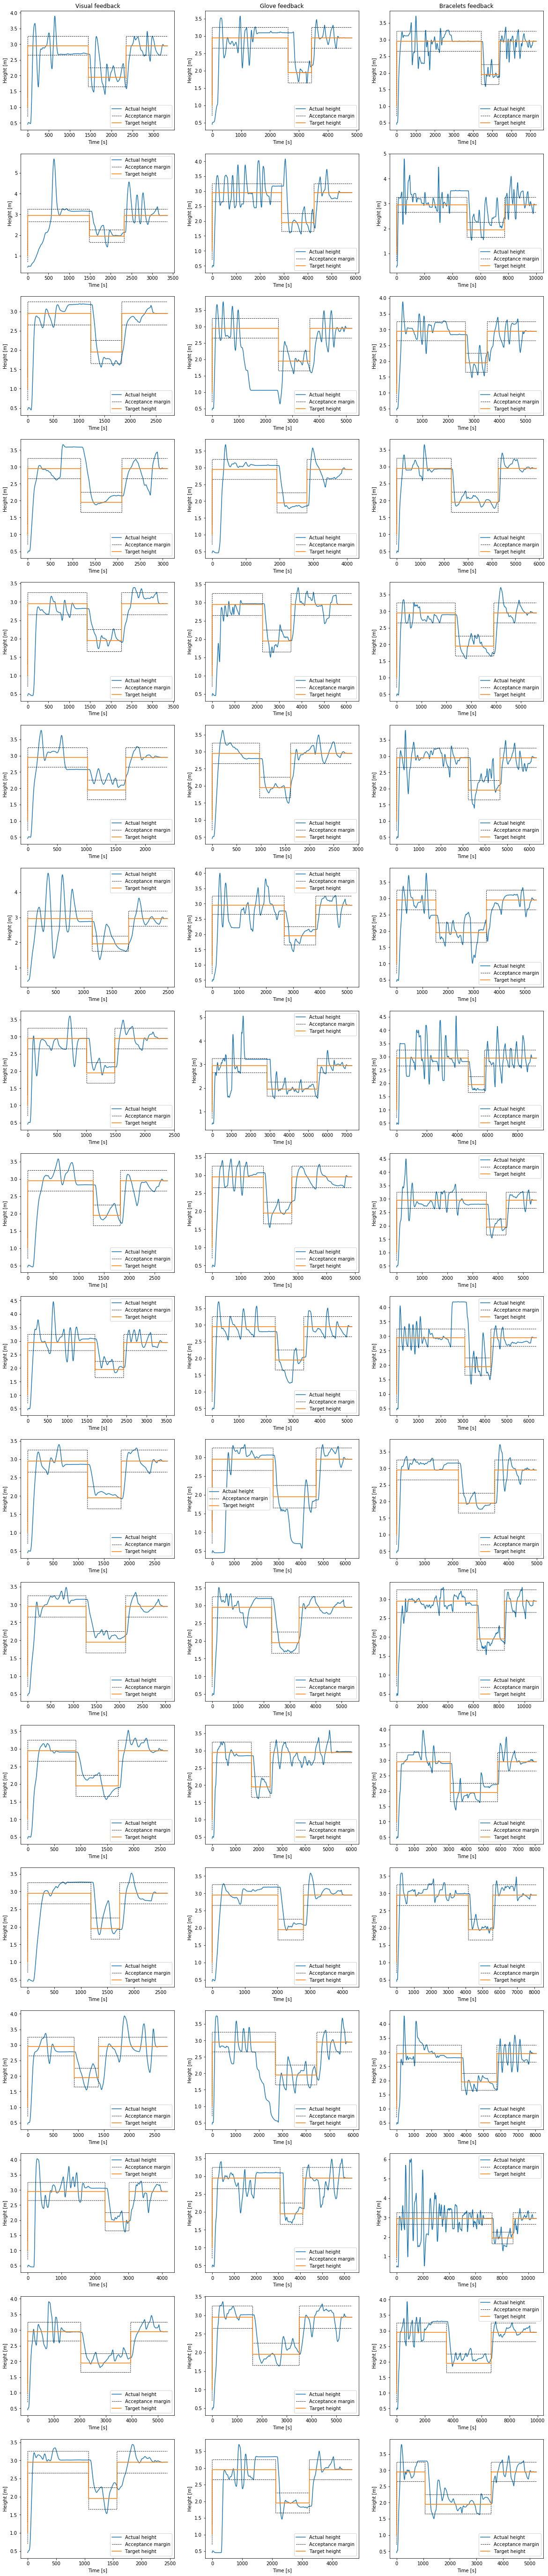

In [115]:
plot_all_sub_trajectories("position_y")

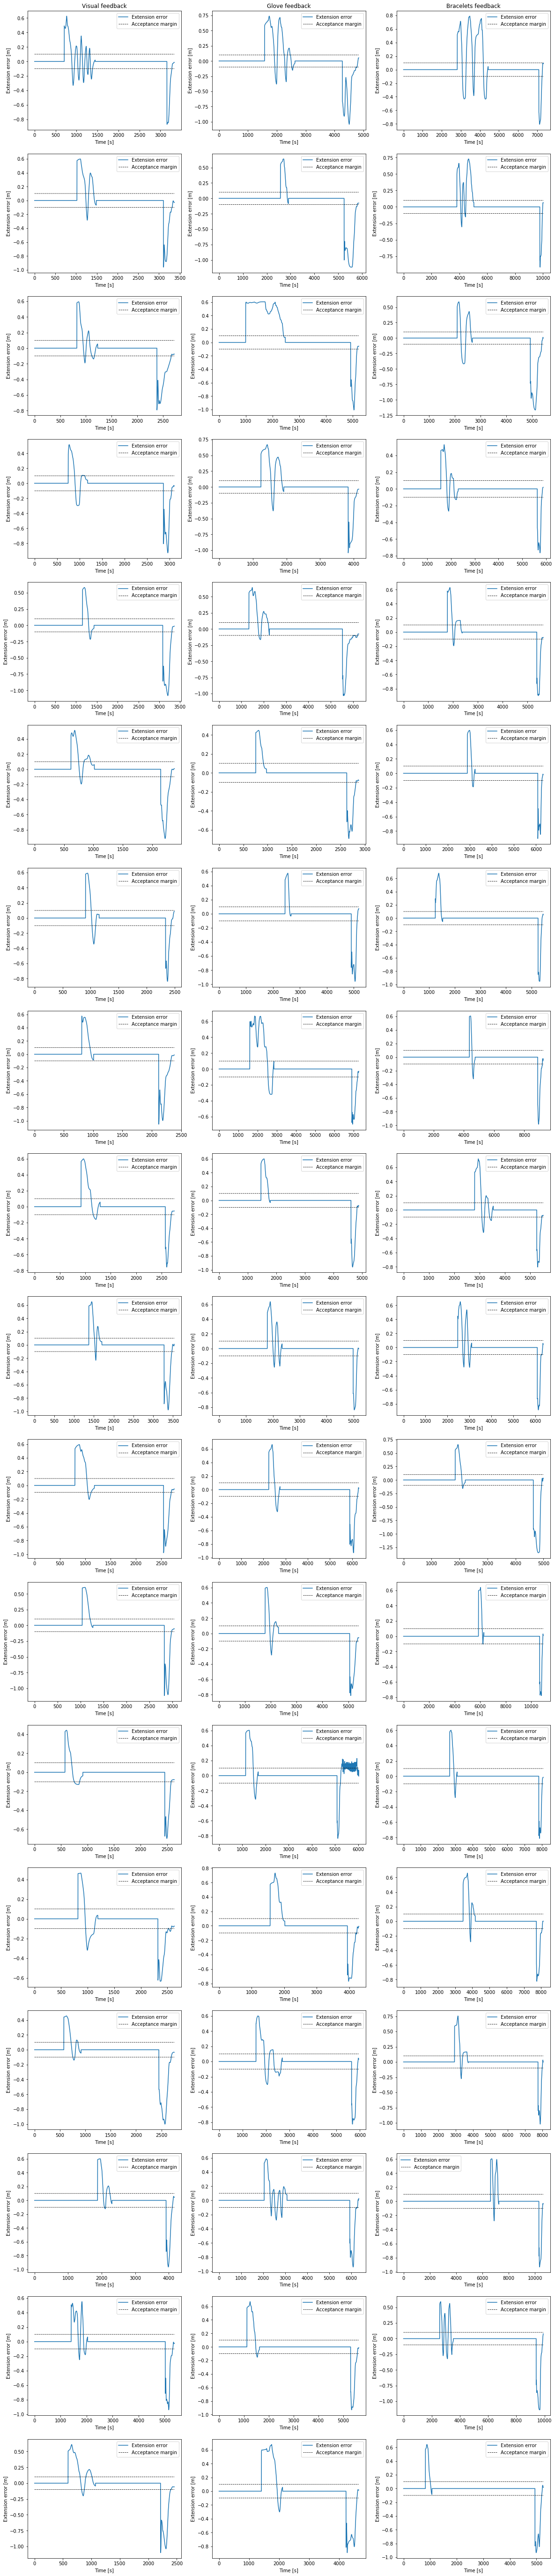

In [116]:
plot_extension_error()

# Plot the time to execute each task

The next plots show the execution time for each task of the mission in the form of boxplots

In [117]:
def get_time(feedback_type, task_type):
    #task_type is a string: "1st_waypoint_time", "2nd_waypoint_time", "3rd_waypoint_time", "extension_time", "contraction_time", "time"
    time_list = []
    files = glob.glob(feedback_type+"\*.csv")
    for file in files:
        data = pd.read_csv(file)
        time_list.append(data[task_type].iloc[-1])
    return time_list

def plot_execution_time(task_type):
    title = task_type
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1,3,1)
    ax.bar([0, 1,2],
       [np.mean(get_time(feedback_types[0], task_type)), np.mean(get_time(feedback_types[1], task_type)),  np.mean(get_time(feedback_types[2], task_type))],
          yerr =[np.std(get_time(feedback_types[0], task_type)), np.std(get_time(feedback_types[1], task_type)), np.std(get_time(feedback_types[2], task_type))])

    plt.xticks(range(3),feedback_types)
#     plt.ylim([0, 20])
    plt.title(title)
    
def plot_all_execution_times():
    i = 1
    for task_type in task_types:
        
        title = task_type
        if i == 1 : fig = plt.figure(figsize=(12, 4))
            
        ax = fig.add_subplot(1,3,i)
        ax.bar([0, 1,2],
           [np.mean(get_time(feedback_types[0], task_type)), np.mean(get_time(feedback_types[1], task_type)),  np.mean(get_time(feedback_types[2], task_type))],
              yerr =[np.std(get_time(feedback_types[0], task_type)), np.std(get_time(feedback_types[1], task_type)), np.std(get_time(feedback_types[2], task_type))])

        plt.xticks(range(3),feedback_types)
    #     plt.ylim([0, 20])
        plt.title(title)
        i+=1
        if i>3: i =1
            
def plot_all_boxplot_execution_time():
    for task_type in task_types:
        plot_boxplot_execution_time(task_type)

def plot_boxplot_execution_time(task_type):
    # Define styling for each boxplot component
    medianprops = {'color': 'magenta', 'linewidth': 2}
    boxprops = {'color': 'black', 'linestyle': '-', 'linewidth':2}
    whiskerprops = {'color': 'black', 'linestyle': '-'}
    capprops = {'color': 'black', 'linestyle': '-'}
    flierprops = {'color': 'black', 'marker': 'x'}
    title = task_type
 
    fig = plt.figure()
    ax = plt.axes()

    width = 0.5
    bp = plt.boxplot([get_time(feedback_types[0], task_type), get_time(feedback_types[1], task_type), get_time(feedback_types[2], task_type)], 
                     widths = width, labels = feedback_types,medianprops=medianprops,
                       boxprops=boxprops,
                       whiskerprops=whiskerprops,
                     patch_artist=True,  # fill with color
                       capprops=capprops,
                       flierprops=flierprops )

    colors = ['pink', 'lightblue', 'lightgreen']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        
    if task_type == "time": task_type = "Total " + task_type
    plt.title(task_type)
    ax.set_xlabel('Feedback type')
    ax.set_ylabel('Time [s]')     
        

    

In [431]:
def check_normality():
    for task_type in task_types:
        column = 0
        fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(4*3,5))
        for feedback_type in feedback_types:    
            distribution = get_time(feedback_type, task_type)
    #         Histogram
            stat, p = shapiro(distribution)
#             print('Statistics=%.3f, p=%.3f' % (stat, p))
            # interpret
            alpha = 0.05
            if p > alpha: 
                result_color = 'lightgreen'
                result_text = 'Sample = Gaussian'
            else: 
                result_color = 'lightsalmon'
                result_text = "Sample != Gaussian"
            ax[0][column].plot([],[], color = result_color, label = result_text)
            ax[0][column].legend()
            ax[0][column].hist(distribution,color = result_color)
            ax[0][column].set_ylabel("Nb of subjects")
            ax[0][column].set_xlabel("Time [s]")
    #         qqplot
            qqplot(np.asarray(distribution), line='s', ax = ax[1][column], color = result_color)
            ax[0][column].set_title(feedback_type)
            column += 1
            plt.tight_layout()    
            plt.suptitle(time_dict[task_type],y = 1.02, ha = 'left')

        
        

    

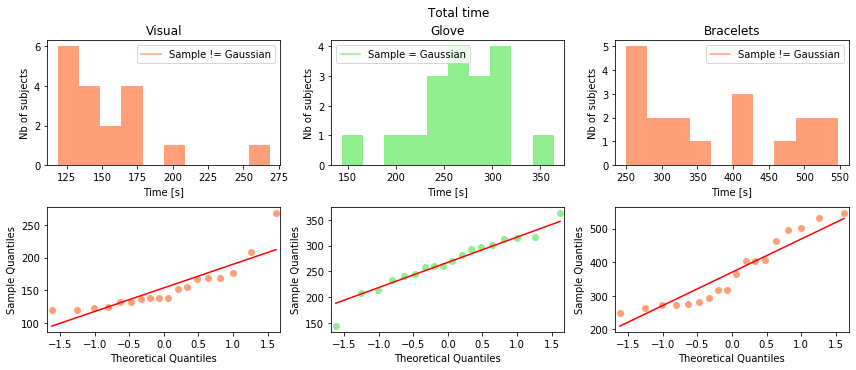

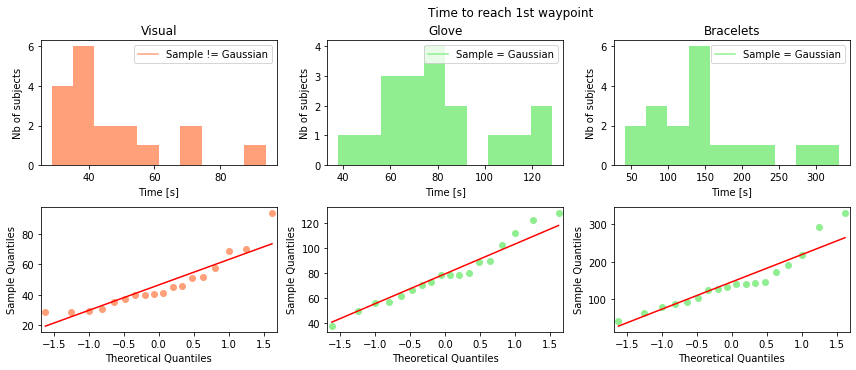

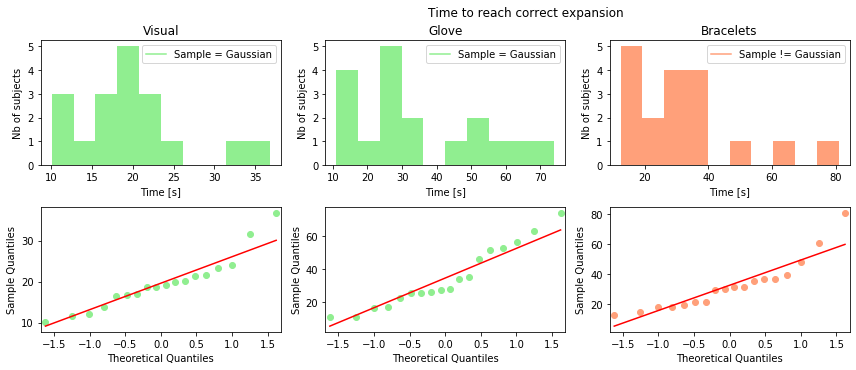

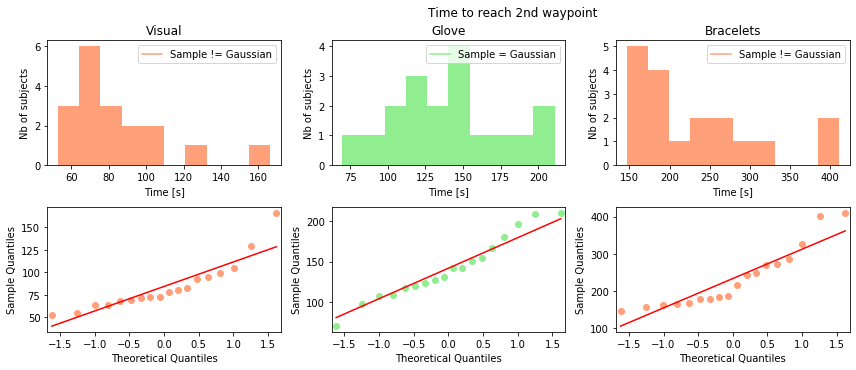

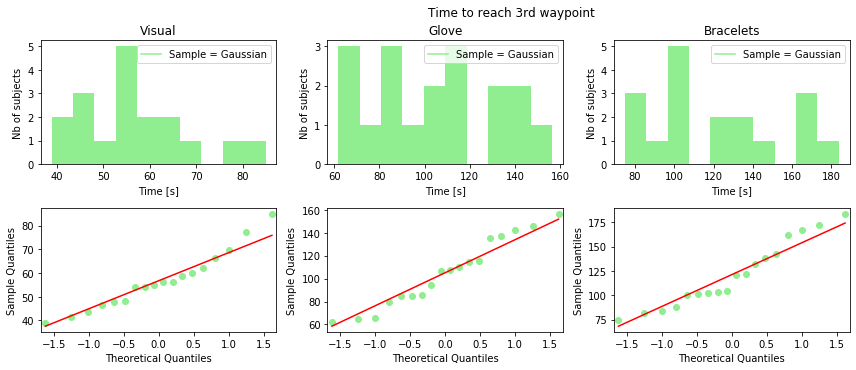

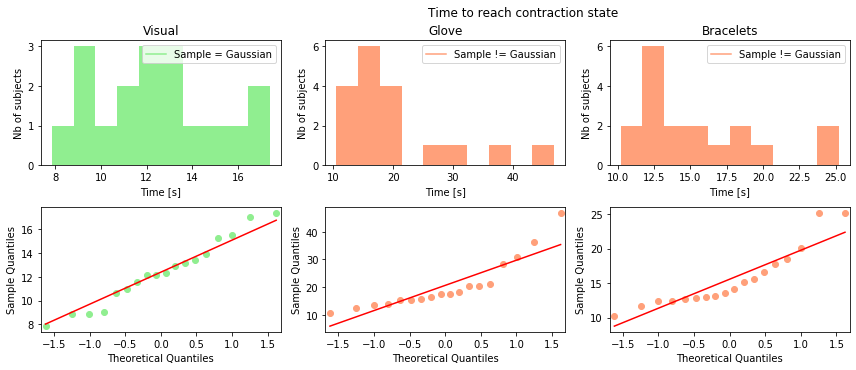

In [432]:
check_normality()

In [271]:
len(task_types)

6

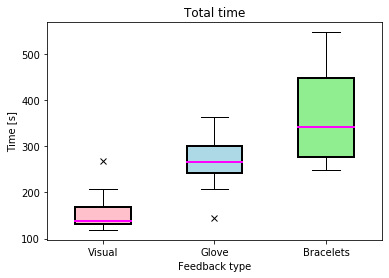

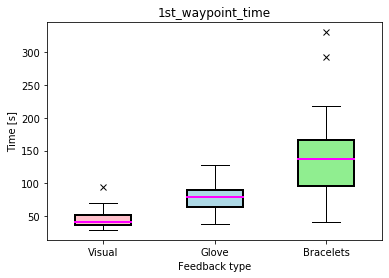

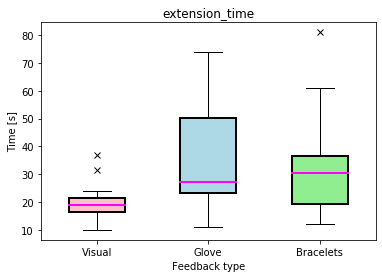

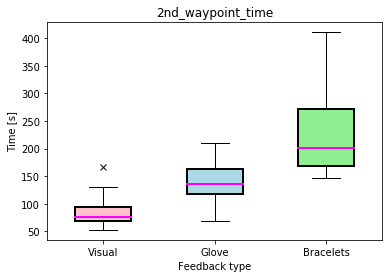

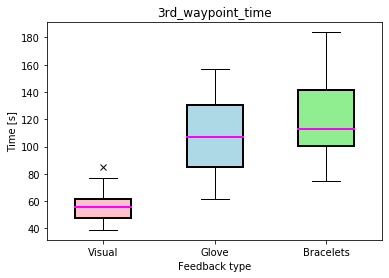

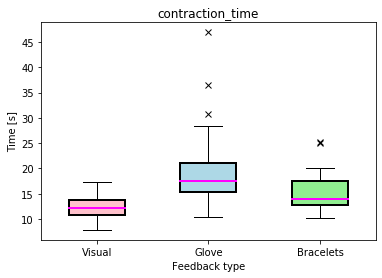

In [118]:
plot_all_boxplot_execution_time()

# Comparison of the haptic feedbacks
In this section, the two haptic feedbacks are compared to the visual feedback for each subject.

Taking into account that the general performance of the subjects could be very different from each other, we chose to use as another metric the ratio between the time required to complete a task with visual feedback and each haptic feedback.

Example : subject1 accomplished the run with visual feedback in 2 minutes, the one with the glove in 4 minutes, and the one with the bracelets in 6 minutes.

the metrics are going to be 4/2 = 2 for the glove, and 6/2 = 3 for the bracelets.

This would be a way to normalize the execution time.

The idea would be to say that:
From the first plot (yes, the statistical analysis is missing for now), we saw that the visual feedback is better.
But to determine which is really the best between the glove and the bracelets, we may need to normalize the time with the visual time to have more meaningful results...

# Question for Claudio :
Do you think this approach would be relevant ? Or is there too much repetition with the first plot ? How could we call this metric (what could we put as an axis label)? 

In [119]:
def get_time_for_each_feedback(task_type):
    final_list = []
    for feedback_type in feedback_types:
        files = glob.glob(feedback_type+"\\sorted\\*.csv")
        time_list = []
        for file in files:
            df = pd.read_csv(file)
            time_list.append(df[task_type].iloc[-1])
        final_list.append(time_list)
        
    return final_list

def get_times_referred_to_visual(task_type):
    times_list = get_time_for_each_feedback(task_type)
    glove_times = []
    brac_times = []
    for i in range (0, len(times_list[0])):
        glove_times.append(times_list[1][i]/times_list[0][i])
        brac_times.append(times_list[2][i]/times_list[0][i])
    return glove_times, brac_times

def plot_times_referred_to_visual(task_type):
    medianprops = {'color': 'magenta', 'linewidth': 2}
    boxprops = {'color': 'black', 'linestyle': '-', 'linewidth':2}
    whiskerprops = {'color': 'black', 'linestyle': '-'}
    capprops = {'color': 'black', 'linestyle': '-'}
    flierprops = {'color': 'black', 'marker': 'x'}
    title = task_type
 
    fig = plt.figure()
    ax = plt.axes()
    
    glove_times, brac_times = get_times_referred_to_visual(task_type)

    width = 0.5
    bp = plt.boxplot([glove_times, brac_times], 
                     widths = width, labels = feedback_types[1:3],medianprops=medianprops,
                       boxprops=boxprops,
                     patch_artist=True,  # fill with color
                       whiskerprops=whiskerprops,
                       capprops=capprops,
                       flierprops=flierprops )

    colors = ['pink', 'lightblue']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    if task_type == "time": task_type = "Total " + task_type
    plt.title(task_type)
    ax.set_xlabel('Feedback type')
    ax.set_ylabel('Time compared to visual time')
    plt.ylim(bottom=0)
    plt.plot([0,3], [1,1], '--k' )

def plot_all_times_referred_to_visual():
    for task_type in task_types:
        plot_times_referred_to_visual(task_type)
    



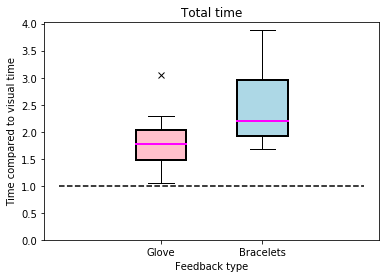

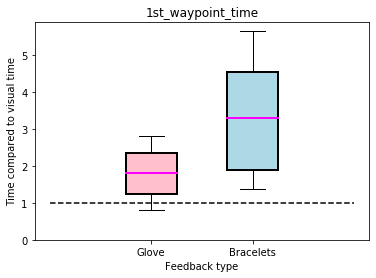

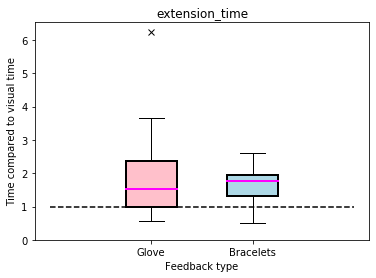

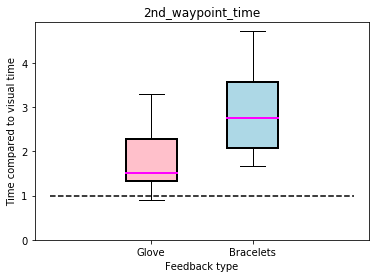

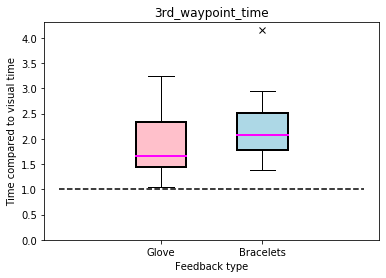

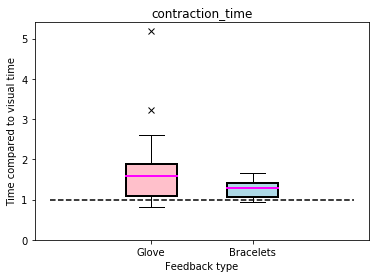

In [120]:
plot_all_times_referred_to_visual()

In [429]:
def check_normality_new():
    column = 0
    for task_type in task_types:
        column = 0
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(4*2,5))
        distributions = get_times_referred_to_visual(task_type)
        for distribution in distributions:
            stat, p = shapiro(distribution)
            if p > alpha: 
                result_color = 'lightgreen'
                result_text = 'Sample = Gaussian'
            else: 
                result_color = 'lightsalmon'
                result_text = "Sample != Gaussian"
            ax[0][column].plot([],[], color = result_color, label = result_text)
            ax[0][column].legend()
    #         Histogram
            ax[0][column].hist(distribution, color = result_color)
            ax[0][column].set_ylabel("Nb of subjects")
            ax[0][column].set_xlabel("Time/Visual time")
            
    #         qqplot
            qqplot(np.asarray(distribution), line='s', ax = ax[1][column], color = result_color)
        
            ax[0][column].set_title(feedback_types[column])
            column += 1
            plt.tight_layout()    
            plt.suptitle(time_dict[task_type],y = 1.02, ha = 'left')
        
        


        

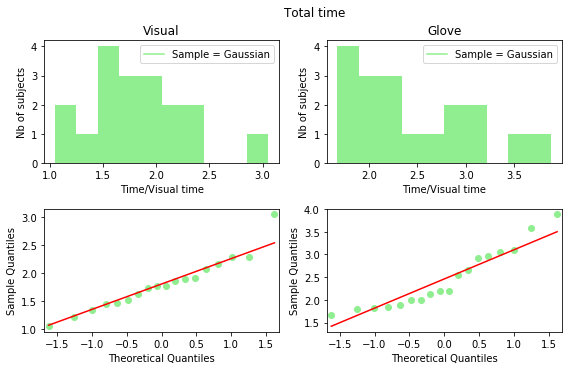

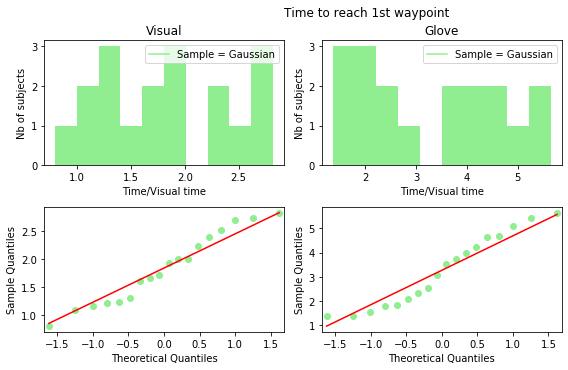

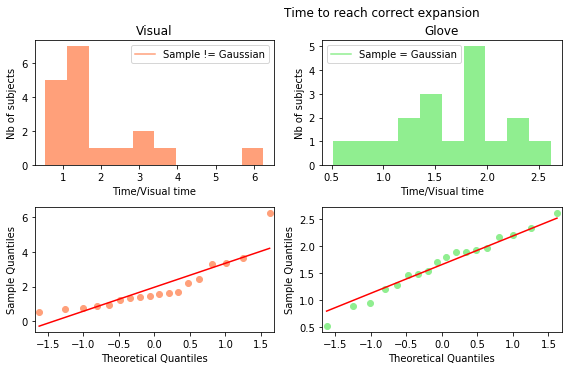

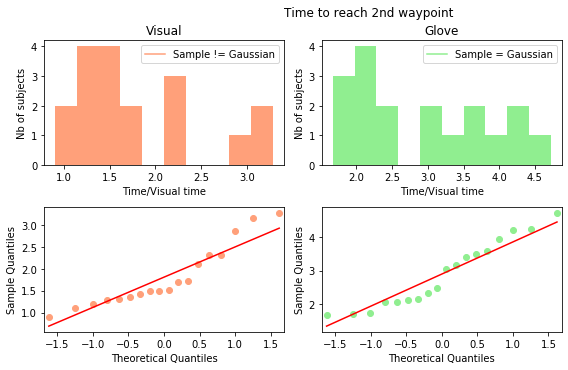

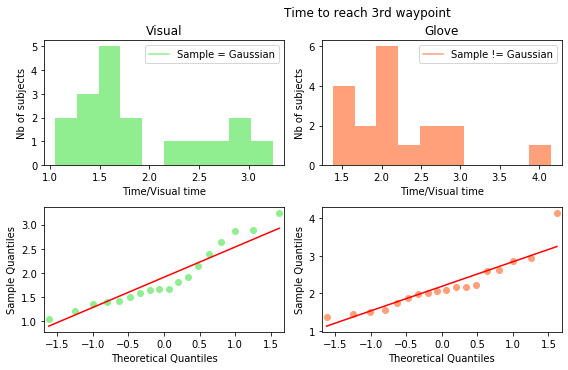

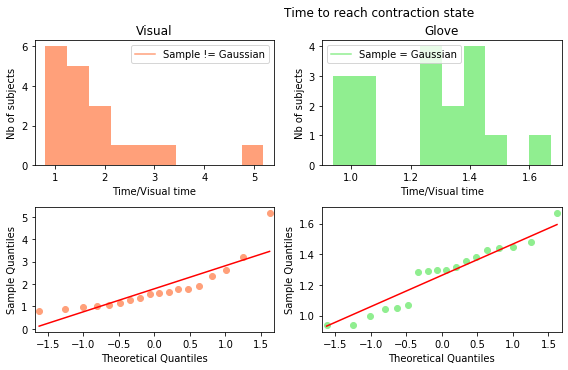

In [430]:
check_normality_new()

# Plot of the total distance

Another metric that has been created is the total distance covered by the swarm

# Question to Claudio
Does this metric seems interesting ??

In [121]:
def total_distance(feedback_type):
    files = glob.glob(feedback_type+"\*.csv")
    total_distances = []
    for file in files:
        data = pd.read_csv(file)
        position_x = data["position_x"]
        position_y = data["position_y"]
        position_z = data["position_z"]
        total_distance = 0
        length = len(position_x)
        for i in range(1,length):
            delta_x = position_x[i] - position_x[i-1]
            delta_y = position_y[i] - position_y[i-1]
            delta_z = position_z[i] - position_z[i-1]
            total_distance += math.sqrt(delta_x*delta_x + delta_y*delta_y + delta_z*delta_z)
        total_distances.append(total_distance)    
            
    return total_distances

def plot_distance():    
    medianprops = {'color': 'magenta', 'linewidth': 2}
    boxprops = {'color': 'black', 'linestyle': '-', 'linewidth':2}
    whiskerprops = {'color': 'black', 'linestyle': '-'}
    capprops = {'color': 'black', 'linestyle': '-'}
    flierprops = {'color': 'black', 'marker': 'x'}
    title = "Total distance covered"
 
    fig = plt.figure()
    ax = plt.axes()

    width = 0.5
    bp = plt.boxplot([total_distance(feedback_type) for feedback_type in feedback_types], 
                     widths = width, labels = feedback_types,medianprops=medianprops,
                       patch_artist=True,  # fill with color
                       boxprops=boxprops,
                       whiskerprops=whiskerprops,
                       capprops=capprops,
                       flierprops=flierprops )
    
    colors = ['pink', 'lightblue', 'lightgreen']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    plt.title(title)
    ax.set_xlabel('Feedback type')
    ax.set_ylabel('Distance covered [m]')
        

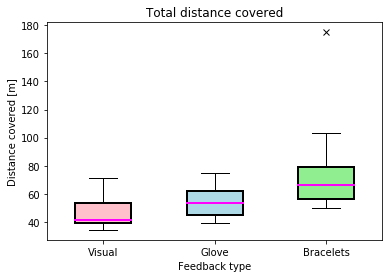

In [122]:
plot_distance()

In [427]:
def check_normality_total_distance():
    
    row = 0
    column = 0
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(4*3,5))
    for feedback_type in feedback_types:
        distribution = total_distance(feedback_type)
        stat, p = shapiro(distribution)
        if p > alpha: 
            result_color = 'lightgreen'
            result_text = 'Sample = Gaussian'
        else: 
            result_color = 'lightsalmon'
            result_text = "Sample != Gaussian"
        ax[0][column].plot([],[], color = result_color, label = result_text)
        ax[0][column].legend()
#         Histogram
        ax[0][column].hist(distribution, color = result_color)
#         qqplot
        qqplot(np.asarray(distribution), line='s', ax = ax[2*row+1][column], color = result_color)
        
        ax[0][column].set_title(feedback_type)
        ax[0][column].set_ylabel("Nb of subjects")
        ax[0][column].set_xlabel("Distance [m]")
        column += 1
        plt.tight_layout()    
        plt.suptitle("Total distance covered",y = 1.02, ha = 'left')
        
    

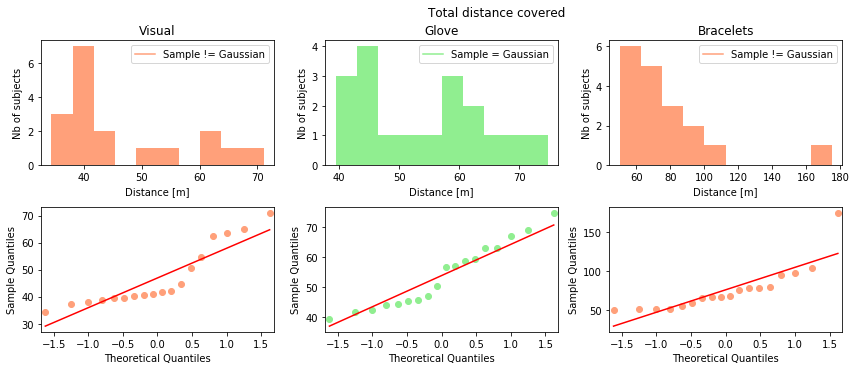

In [428]:
check_normality_total_distance()


#Last metric

Another metric used to analyze the data has been created. The idea was to count the number of time the actual position is getting outside of the acceptance margin before stabilizing inside the margin (after a new target instruction is received). It is some kind of an overshoot measurement, but to call it an overshoot would be confusing...

Ex : the swarm flies at a height of 2m. The next target is 3m, so the feedback system indicates to go up. Following the fb system, the subjects goes up, but too high, reaching 3.5 m, which is higher than the accepted margin of 0.2 m (exemple value). So the fb system indicates to go down again. the subj. goes down to 2.7 m, again outside of the margin... The fb system indicates to go up again, and finally the subject stabilize at 3.1 m, inside the acceptance margin. 

n this case, the metric would be 2, because the subject overpassed twice the correct margin...

# Question to Claudio
Do you have an idea of how we could call this metric ?

In [125]:
def get_overshoot_count_by_type(feedback_type, error_type):
    #feedback_type : string, "Visual", "Glove", "Bracelets"
    #error_type : string, height_error, x_error, z_error, extension_error
    error_list = []
    max_error = 0
    
    overshoot_list = []
    
    files = glob.glob(feedback_type+"\*.csv")
    for file in files:
        data = pd.read_csv(file)
        if error_type == "height_error":
            error_list = data["height_error"]
            max_error = max_height_error
        elif error_type == "x_error":
            error_list = data["target_position_x"]-data["position_x"]
            max_error = max_distance_error
        elif error_type == "z_error":
            error_list = data["target_position_y"]-data["position_y"]
            max_error = max_distance_error
        elif error_type == "extension_error":
            error_list = data["extension_error"]
            max_error = max_contraction_error
        else : 
            print("incorrect error_type")
            return
        overshoot_list.append(get_overshoot_count(error_list, max_error))
        
    return overshoot_list

def get_overshoot_count(error_list, max_error):
    wasOk = False
    overshoot_count = 0
    for point in error_list:
        if point > 0.1*max_error:
            if wasOk:
                overshoot_count += 1
                wasOk = False
        elif point < -0.1*max_error:
            if wasOk:
                overshoot_count += 1
                wasOk = False
        else: wasOk = True
    return overshoot_count-1 # - 1 because at the begining, it is not an overshoot

def get_overshoot_count_mean_and_std(feedback_type, error_type):
    #feedback_type : string, "Visual", "Glove", "Bracelets"
    #error_type : string, height_error, x_error, z_error, extension_error
    error_list = []
    max_error = 0
    
    overshoot_list = []
    
    files = glob.glob(feedback_type+"\*.csv")
    for file in files:
        data = pd.read_csv(file)
        if error_type == "height_error":
            error_list = data["height_error"]
            max_error = max_height_error
        elif error_type == "x_error":
            error_list = data["target_position_x"]-data["position_x"]
            max_error = max_distance_error
        elif error_type == "z_error":
            error_list = data["target_position_y"]-data["position_y"]
            max_error = max_distance_error
        elif error_type == "extension_error":
            error_list = data["extension_error"]
            max_error = max_contraction_error
        else : 
            print("incorrect error_type")
            return
        overshoot_list.append(get_overshoot_count(error_list, max_error))
        
    return [np.mean(np.asarray(overshoot_list)), np.std(np.asarray(overshoot_list))]

def plot_overshoot( error_type):    
    mean_and_std_list =[ get_overshoot_count_mean_and_std(feedback_type, error_type) for feedback_type in feedback_types]
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1,3,1)
    ax.bar([0, 1,2],
       [mean_and_std_list[0][0], mean_and_std_list[1][0], mean_and_std_list[2][0]],
          yerr =[mean_and_std_list[0][1], mean_and_std_list[1][1], mean_and_std_list[2][1]])

    plt.xticks(range(3),feedback_types)
    plt.ylim([0, 20])
    plt.title('Nb of overshoot for '+ error_type)
    

def plot_all_overshoot():
    i = 1
    for error_type in error_types:
        mean_and_std_list =[get_overshoot_count_mean_and_std(feedback_type, error_type) for feedback_type in feedback_types]
        if i == 1:    fig = plt.figure(figsize=(12, 4))

        ax = fig.add_subplot(1, 3, i)
        ax.bar([0, 1,2],
           [mean_and_std_list[0][0], mean_and_std_list[1][0], mean_and_std_list[2][0]],
              yerr =[mean_and_std_list[0][1], mean_and_std_list[1][1], mean_and_std_list[2][1]])

        plt.xticks(range(3),feedback_types)
        plt.ylim([0, 20])
        plt.title('Nb of overshoot for '+ error_type)    
        i+=1
        if i > 3 : i = 1

def plot_overshoot_boxplot(error_type):
    medianprops = {'color': 'magenta', 'linewidth': 2}
    boxprops = {'color': 'black', 'linestyle': '-', 'linewidth':2}
    whiskerprops = {'color': 'black', 'linestyle': '-'}
    capprops = {'color': 'black', 'linestyle': '-'}
    flierprops = {'color': 'black', 'marker': 'x'}
    title = error_dict[error_type]
 
    fig = plt.figure()
    ax = plt.axes()

    width = 0.5
    bp = plt.boxplot([get_overshoot_count_by_type(feedback_types[0], error_type), get_overshoot_count_by_type(feedback_types[1], error_type), get_overshoot_count_by_type(feedback_types[2], error_type)], 
                     widths = width, labels = feedback_types,medianprops=medianprops,
                       patch_artist=True,  # fill with color
                       boxprops=boxprops,
                       whiskerprops=whiskerprops,
                       capprops=capprops,
                       flierprops=flierprops )
    
    colors = ['pink', 'lightblue', 'lightgreen']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    plt.title(title)
    ax.set_xlabel('Feedback type')
    ax.set_ylabel('Number of ??')
    
def plot_all_overshoot_boxplot():
    for error_type in error_types :
        plot_overshoot_boxplot(error_type)


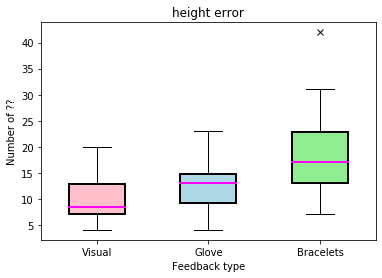

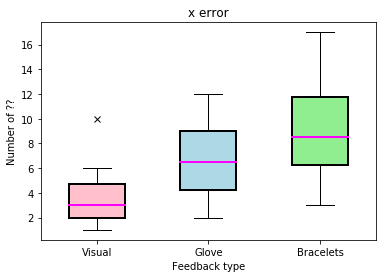

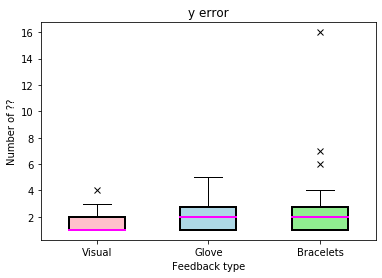

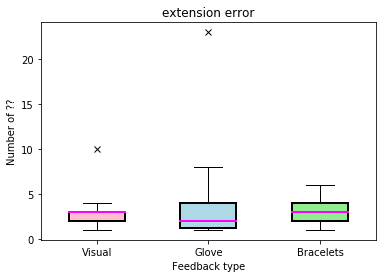

In [126]:
plot_all_overshoot_boxplot()

In [422]:
def check_normality_overshoot():
    for error_type in error_types:
        column = 0
        fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(4*3,5))
        for feedback_type in feedback_types:
            distribution = get_overshoot_count_by_type(feedback_type, error_type)
            stat, p = shapiro(distribution)
            if p > alpha: 
                result_color = 'lightgreen'
                result_text = 'Sample = Gaussian'
            else: 
                result_color = 'lightsalmon'
                result_text = "Sample != Gaussian"
            ax[0][column].plot([],[], color = result_color, label = result_text)
            ax[0][column].legend()
    #         Histogram
            ax[0][column].hist(distribution, color = result_color)
    #         qqplot
            qqplot(np.asarray(distribution), line='s', ax = ax[1][column], color = result_color)
            ax[0][column].set_title(feedback_type)
            
            column += 1
            plt.tight_layout()  
            
            plt.suptitle(error_dict[error_type],y = 1.02, ha = 'left')
            
        

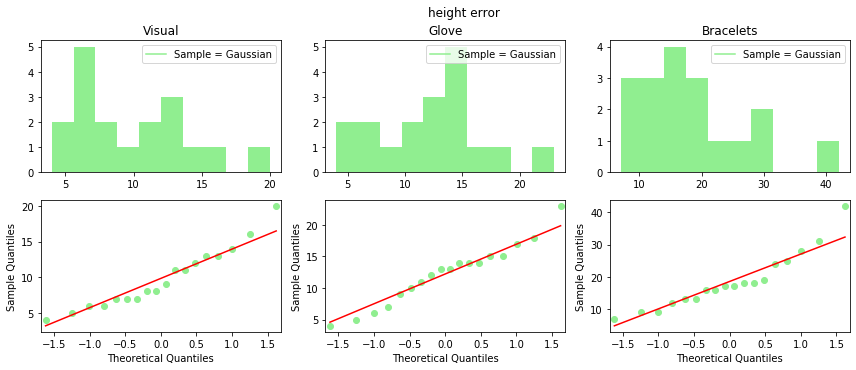

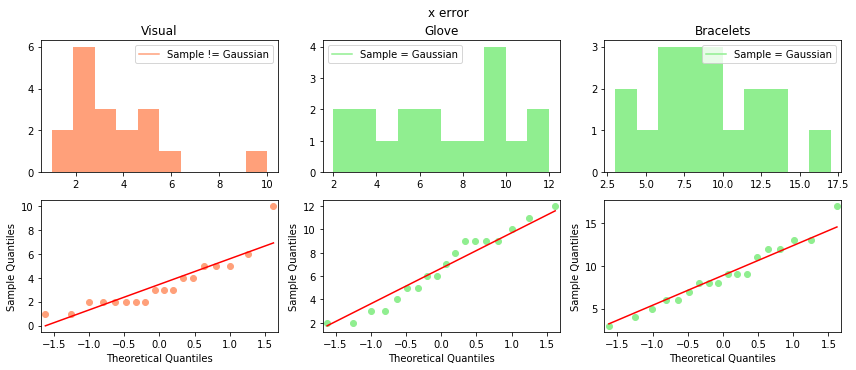

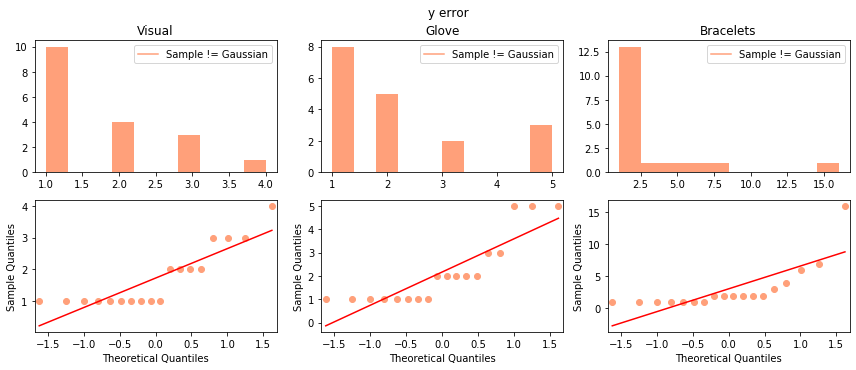

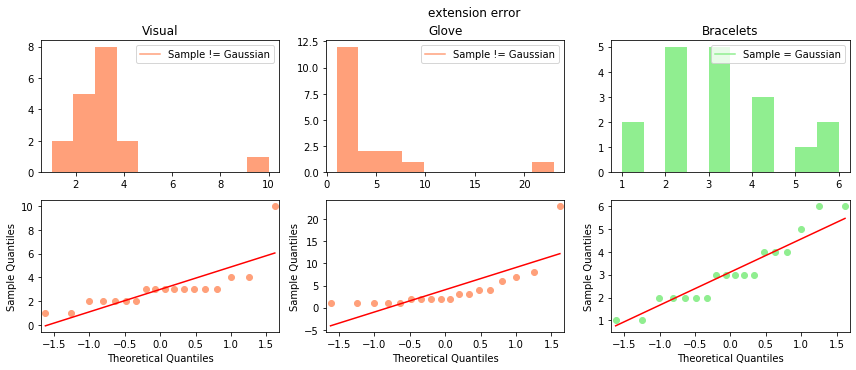

In [423]:
check_normality_overshoot()

Not used for now

In [104]:
def plot_height(feedback_type):
    files = glob.glob(feedback_type+"\sorted\*.csv")
    for file in files:
        data = pd.read_csv(file)
        plt.figure()
        plt.plot(data["position_y"])
        plt.plot(data["target_position_y"]+1)
        plt.plot(data["target_position_y"]+1+np.ones(len(data["height_error"]))*0.1*max_height_error)
        plt.plot(data["target_position_y"]+1-np.ones(len(data["height_error"]))*0.1*max_height_error)
        
        plt.title("Height")
        plt.figure()
        plt.plot(data["height_error"])
        plt.plot(np.ones(len(data["height_error"]))*0.1*max_height_error)
        plt.plot(np.ones(len(data["height_error"]))*(-0.1*max_height_error))
        plt.plot(np.zeros(len(data["height_error"])))
        
def plot_x_distance(feedback_type):
    files = glob.glob(feedback_type+"\sorted\*.csv")
    for file in files:
        data = pd.read_csv(file)
        plt.figure()
        plt.plot(data["position_x"])
        plt.plot(data["target_position_x"])
        plt.plot(data["target_position_x"]+np.ones(len(data["target_position_x"]))*0.1*max_distance_error)
        plt.plot(data["target_position_x"]-np.ones(len(data["target_position_x"]))*0.1*max_distance_error)
        
        plt.title("X distance")
        plt.figure()
        plt.plot(data["target_position_x"]- data["position_x"])
        plt.plot(np.ones(len(data["target_position_x"]))*0.1*max_distance_error)
        plt.plot(np.ones(len(data["target_position_x"]))*(-0.1*max_distance_error))
        plt.plot(np.zeros(len(data["target_position_x"])))
        
def plot_z_distance(feedback_type):
    files = glob.glob(feedback_type+"\sorted\*.csv")
    for file in files:
        data = pd.read_csv(file)
        plt.figure()
        plt.plot(data["position_z"])
        plt.plot(data["target_position_z"])
        plt.plot(data["target_position_z"]+np.ones(len(data["target_position_z"]))*0.1*max_distance_error)
        plt.plot(data["target_position_z"]-np.ones(len(data["target_position_z"]))*0.1*max_distance_error)
        
        plt.title("z distance")
        plt.figure()
        plt.plot(data["target_position_z"]- data["position_z"])
        plt.plot(np.ones(len(data["target_position_z"]))*0.1*max_distance_error)
        plt.plot(np.ones(len(data["target_position_z"]))*(-0.1*max_distance_error))
        plt.plot(np.zeros(len(data["target_position_z"])))        